# TempEst-NEXT Validation Suite

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of ~400 (nominal) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on hindcasting for computational convenience.  It is assumed that any performance discrepancies in forecasting vs hindcasting would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model hindcasting and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged hindcasting and forecasting performance
3. Ungaged-region hindcasting performance
4. Ungaged-elevation hindcasting performance
5. Ungaged-time-period hindcasting performance
6. Disturbance hindcasting performance
7. Small-stream hindcasting performance?

## Tests

The following tests are used to assess the above performance characteristics.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the development dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast periods of 2, 3 (HRRR), 7, 10, 14, 17 (GFS/GEFS) days.  Note forecast period is 1 day *past* the last day of the weather forecast, since NEWT does not depend on day-of weather.
  - Use meteorology estimates for training and forecasts for testing: evaluate the impact of heterogeneous datasets.  Use 2-day HRRR-forced forecast only.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Hindcasting (met estimate) only.
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for a range of lead times
  - Train on estimates/test on forecasts (forecast with heterogeneous data)
- Extrapolation hindcasting tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All hindcasting.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
- Regime-shift hindcasting: identify a set of watersheds for which the observed thermal regime has shifted significantly.  Train the model on everything else, then try to predict the disturbed watersheds and see how the model performs.  This assesses whether TempEst-NEXT is capable of capturing regime shifts.
- Small-stream hindcasting: if possible, use the model to predict temperatures at very small (e.g., first-order headwaters, centimeters to a few meters wide) streams where some observations are available, just to see if it works there.

# Data Preparation

In [1]:
import NEXT
import NEWT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
bp = "/scratch/dphilippus/notebooks/next_validation/"

There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [ ]:
dev_data = pd.read_csv(bp + "DevData.csv", dtype={"id": "str"})
dev_data["date"] = pd.to_datetime(dev_data["date"])
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
# dev_data["day"] = dev_data["date"].dt.day_of_year
# gsamp = pd.read_csv("GageSample.csv",
#                    dtype={"id": "str"})
# def idfix(data):
#     data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
#     data["id"] = data["id"].apply(lambda x: x.split("_")[1])
#     return data
# lcov = idfix(pd.read_csv("LandCover.csv"))
# area = idfix(pd.read_csv("Area.csv"))
# topo = idfix(pd.read_csv("Topography.csv"))
# dev_data = dev_data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
# dev_data.to_csv("DevData.csv", index=False)
# test_data = whatever

# Calibrated Tests

In [41]:
def cut_dev(gid, start=None):
    idd = dev_data[dev_data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid)
    try:
        if cutoff is not None:
            test = cal_fn(gid, cutoff)
            model = NEWT.Watershed.from_data(train)
            return model.run_series(test)
    except Exception as e:
        print(e)

## Hindcast

In [42]:
with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x) for x in dev_data["id"].unique()])

'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'
'NoneType' object has no attribute 'generate_ts'


In [51]:
preds = preds[abs(preds["anom"]) < 10]  # I don't know why one of the models is predicting colossal anomalies, but it is.

Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, when a massive outlier that was predicting anomalies in the thousands of degrees is removed, global performance is very similar to gagewise performance.  Note that huge anomaly sensitivity isn't representative of any real use case, since in a calibrated model that would be corrected for and the (smoothed) coefficient estimation model won't predict such high sensitivity.  (If it did happen, it would be fairly obvious that ~3000 C is not a reasonable estimate.)

In [48]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

               R2        RMSE         NSE  StationaryNSE  ClimatologyNSE  \
count  943.000000  943.000000  943.000000     943.000000      943.000000   
mean     0.921120    1.567262    0.919433       0.976682        0.951546   
std      0.097137    0.485112    0.100530       0.017775        0.051659   
min      0.088175    0.121245    0.080547       0.855635        0.287647   
25%      0.920707    1.311004    0.919830       0.969289        0.935658   
50%      0.944844    1.529255    0.944183       0.980622        0.958143   
75%      0.961753    1.757990    0.960944       0.988834        0.979532   
max      0.988151    7.747312    0.987592       0.999138        1.000000   

       AnomalyNSE       Pbias        Bias     MaxMiss  
count  833.000000  943.000000  943.000000  943.000000  
mean     0.152678    0.071368    0.006446    1.292032  
std      3.812618    0.761416    0.085490    0.881240  
min    -77.248323   -9.045063   -1.071342    0.015025  
25%      0.309765   -0.133994   -0.

In [49]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.959498,1.573854,0.959488,0.983768,0.607717,0.902755,0.033256,0.004434,1.905588


## Forecast

### HRRR

### GFS/GEFS

## Heterogeneous Forecast

# Gagewise Cross-Validation

Runtime on Wendian (all runs included threshold sensitivity engine):

- No climate engine: 1.75 hours.  Most of the time is spent predicting, not training, so coefficient estimation + prediction is approx. 6-7 seconds per watershed.  As the average watershed has 9 years of data, that makes slightly under 1 second per year.
- 1-year lookback: 2.06 hours, so ~20% longer than no-climate, making 8 seconds per watershed (but probably slightly longer in practice, with a crash rate of several percent) - call it 10 seconds, or a little over 1 second per year.
- 2-year: 1.96 hours
- 3-year: ~2 hours
- 4-year: ~2 hours

Etc.  Runtime is roughly constant at 2 hours for all lookback windows.  No errors occurred for 10-year lookback, and only one site had errors for 2-7 year lookback.  Thus, there's no computational reason not to use a performance-optimal lookback window.

In [3]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [9]:
clim=True
# lookbacks=[1, 2, 3, 4, 5, 7, 10]
lookbacks = [10]
timing = bp + "results/kfold_times.txt"
with warnings.catch_warnings(action="ignore"):
    # kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=bp + f"results/kfold_coefficients{'_withclim_lookback' + str(lookback) if clim else ''}.csv", redo=False)
    # kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=bp + "results/kfold_nothreshold.csv")
    for lookback in lookbacks:
        start = time.time()
        kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=bp + f"results/kfold{'_withclim_lookback' + str(lookback) if clim else ''}.csv", redo=False)
        out = f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations"
        print(out)
        with open(timing, "a") as f:
            f.write(out)


Lookback: 10 :  0.00 hours for 930 sites with 2991926 observations


In [ ]:
persum = lambda x: pd.DataFrame(x.assign(date = lambda y: pd.to_datetime(y["date"])).groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False).median()).T
files = [f for f in os.listdir(bp + "results/") if f.startswith("kfold") and f.endswith(".csv")]
with warnings.catch_warnings(action="ignore"):
    results = pd.concat([persum(pd.read_csv(bp + "results/" + f)).assign(name=f[len("kfold_"):-len(".csv")]) for f in files]).set_index("name")

As currently implemented (10/19/2024), optimal performance is with a threshold engine but no climate engine, although the difference is marginal compared to no-threshold or to climate engines with long lookback windows.  At two significant figures, global performance is identical between the top three (threshold/no-climate, no-threshold/no-climate, lookback-10), though no-threshold/no-climate has somewhat worse anomaly performance.  Max-miss actually does slightly better for midrange lookbacks, but not by much.

The takeaway here is that the threshold engine pays off (barely), while the use of climate engines is dependent on the modeling objective.  Since they perform equally well for the relatively short periods of record tested here (many sites would never activate a longer-lookback climate engine), it's probable that the climate engines would be advantageous for much longer periods of record, which is difficult to test rigorously due to the scarcity of long-record gages.  (It's probably worth picking a few to test, though.)

In [8]:
results.sort_values("RMSE")

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
name,,,,,,,,,
,0.935658,2.104871,0.895683,0.980213,0.928499,0.500258,2.264723,0.278198,2.207649
nothreshold,0.935871,2.119488,0.895980,0.980213,0.928499,0.484630,2.227613,0.276304,2.180027
withclim_lookback10,0.934962,2.124203,0.895292,0.980213,0.928499,0.496699,2.346358,0.287799,2.186546
withclim_lookback7,0.933361,2.127099,0.892453,0.980223,0.928503,0.488934,2.345096,0.290296,2.175394
withclim_lookback5,0.931042,2.149094,0.891897,0.980223,0.928503,0.458962,2.170879,0.282565,2.134465
withclim_lookback4,0.928368,2.180095,0.889555,0.980223,0.928503,0.439446,2.182816,0.304378,2.085539
withclim_lookback3,0.923473,2.223593,0.883556,0.980223,0.928503,0.375331,2.345359,0.315000,2.129757
withclim_lookback2,0.911331,2.340160,0.870987,0.980223,0.928503,0.240479,2.307644,0.304747,2.073170
withclim_lookback1,0.811808,3.405257,0.639920,0.980398,0.929014,-0.738396,3.168666,0.401145,3.598921


## Plots

In [15]:
psum = kfr.assign(date = lambda y: pd.to_datetime(y["date"])).groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()

<Axes: xlabel='lon', ylabel='lat'>

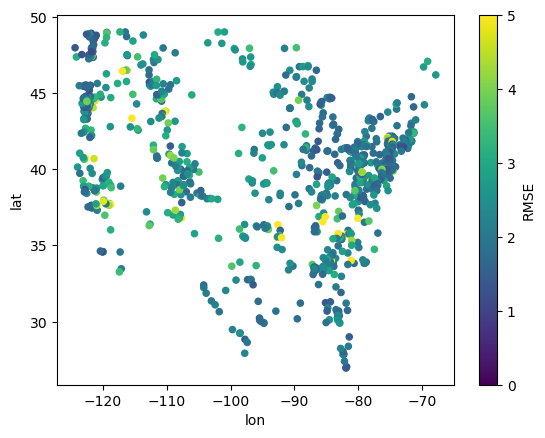

In [21]:
psum.plot.scatter(x="lon", y="lat", c="RMSE", clim=(0,5))

# Test Set Validation

## Hindcast

## Forecast

### HRRR

### GFS/GEFS

## Heterogeneous Forecast

# Extrapolation Tests

## Regional

## Elevation

## Walk-Forward

# Regime Shift/Disturbance

# Small Stream

# True Forecast